

The aim of this project is to develop a regression model that can predict the probability of a student getting admitted to a graduate school. The data used for this project is obtained from Acharya et al.'s "Graduate Admissions" dataset, which includes the following parameters: GRE Scores (maximum score of 340), TOEFL Scores (maximum score of 120), University Rating (rated on a scale of 1 to 5), Statement of Purpose and Letter of Recommendation Strength (both rated on a scale of 1 to 5), Undergraduate GPA (maximum score of 10), Research Experience (either 0 or 1), and Chance of Admit (ranging from 0 to 1).

To achieve this objective, I have experimented with five different regression algorithms: Ridge regression, Support Vector Machines (SVM), Multi-Layer Perceptron (MLP), Random Forest, and K-Nearest Neighbors (KNN).

In [36]:
# import everything needed to get started
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [37]:
# load dataset

df = pd.read_csv('Admission_Predict.csv', index_col=[0])
df

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...
396,324,110,3,3.5,3.5,9.04,1,0.82
397,325,107,3,3.0,3.5,9.11,1,0.84
398,330,116,4,5.0,4.5,9.45,1,0.91


Here I have implemented five-fold cross validation to compare performance of each ML algorithm. 

In [38]:
#five fold corss val from my previous projects:
def fiveFoldCrossVal(inputs, targets, clf):
    def five_fold(inputs, targets):
        DInputs = []
        DTargets = []
        DDict = {'d1': [], 'd2': [], 'd3': [], 'd4': [], 'd5': []}
        DTarDict = {'d1': [], 'd2': [], 'd3': [], 'd4': [], 'd5': []}
        for x in range(len(inputs)):
            DDict['d' + str((x % 5) + 1)].append(inputs[x])
            DTarDict['d' + str((x % 5) + 1)].append(targets[x])
        for k in DDict.keys():
            DInputs.append(np.array(DDict[k]))
            DTargets.append(np.array(DTarDict[k]))
        return DInputs, DTargets
    D, t = five_fold(inputs, targets)
    scores = []
    for i in range(len(D)):
        X_test = D[i]
        X_train = []
        y_test = t[i]
        y_train = []
        for j in range(len(D)):
            if i != j:
                X_train.extend(D[j])
                y_train.extend(t[j])
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        scores.append(score)

    return np.mean(scores)

Our next step is to preprocess our data, since there is both continuous and discrete features, they must be processed separately.

In [39]:
# preprocessing on discrete features
universities = df['University Rating']
research_df = df['Research']
university_df = pd.DataFrame(columns=['1', '2', '3', '4', '5'])
for student in universities:
    university_df = university_df.append({str(i): 0 if i != student else 1 for i in range(1, 6)}, ignore_index=True)
university_df = university_df.set_index(research_df.index)
discrete = [research_df, university_df]
discrete_df = pd.concat(discrete, axis=1)

C:\Users\samta\AppData\Local\Temp\ipykernel_12604\3193829876.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  university_df = university_df.append({str(i): 0 if i != student else 1 for i in range(1, 6)}, ignore_index=True)
C:\Users\samta\AppData\Local\Temp\ipykernel_12604\3193829876.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  university_df = university_df.append({str(i): 0 if i != student else 1 for i in range(1, 6)}, ignore_index=True)
C:\Users\samta\AppData\Local\Temp\ipykernel_12604\3193829876.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  university_df = university_df.append({str(i): 0 if i != student else 1 for i in range(1, 6)}, ignore_index=True)
C:\Users\samta\AppData\Local\Temp\ipykernel_12604\31938

 preparing some data for analysis by scaling its continuous features. It selects two groups of continuous features from the original dataset, concatenates them together, and scales the resulting data to make it easier to work with. The scaled data is saved in a new DataFrame called scaledDF.

In [40]:
# preprocessing on continuous features
from sklearn.preprocessing import StandardScaler
continuousDF1 = df[df.columns[0:2]]
continuousDF2 = df[df.columns[3:6]]
continuous = [continuousDF1, continuousDF2]
continuousDF = pd.concat(continuous, axis=1)

scalar = StandardScaler().fit(continuousDF)
scaled = scalar.transform(continuousDF)
scaledDF = pd.DataFrame(scaled, index=df.index)

In [41]:
# combine discrete and contintuous
frames = [scaledDF, discrete_df]
transformedDF = pd.concat(frames, axis=1)

X = np.array(transformedDF)
y = np.array(df[df.columns[-1]])

In [42]:
# test five-fold cross validation

ridgeAccuracy = fiveFoldCrossVal(X, y, Ridge())
svrAccuracy = fiveFoldCrossVal(X, y, SVR())
mlpAccuracy = fiveFoldCrossVal(X, y, MLPRegressor(max_iter=500))
rfAccuracy = fiveFoldCrossVal(X, y, RandomForestRegressor())
knnAccuracy = fiveFoldCrossVal(X, y, KNeighborsRegressor())
print(f"Ridge Regression: {ridgeAccuracy}")
print(f"SVR: {svrAccuracy}")
print(f"MLP Regressor: {mlpAccuracy}")
print(f"Random Forest: {rfAccuracy}")
print(f"KNN: {knnAccuracy}")

Ridge Regression: 0.7944625009102879
SVR: 0.6992657813919957
MLP Regressor: 0.42811178344875406
Random Forest: 0.7561646190316642
KNN: 0.7533921040574338


Below I used the learning curve plotting function from the scikit-learn site to plot my learning curve with a few modifications
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [43]:


import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

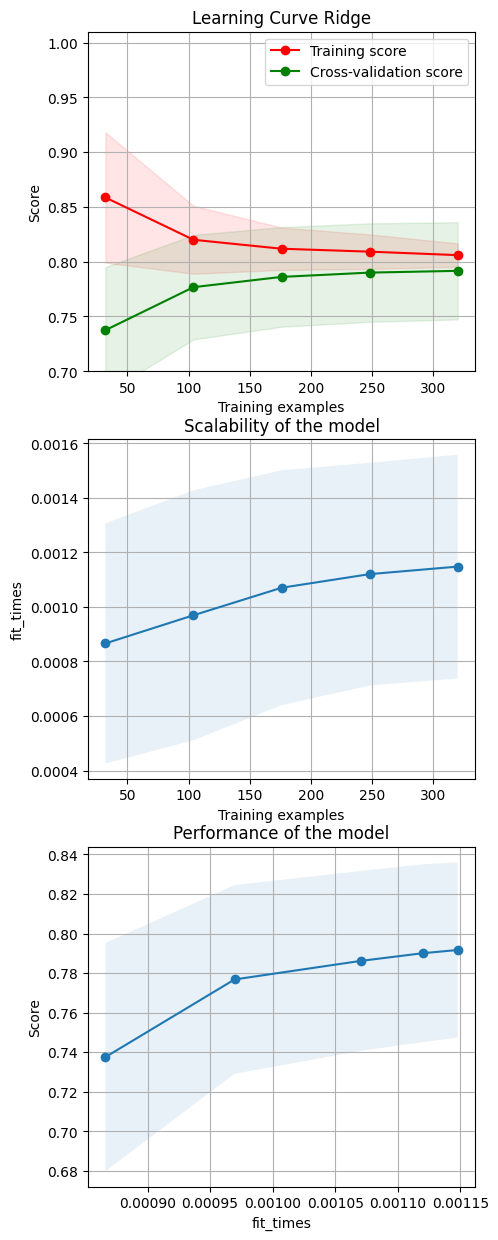

In [44]:
# plotting learning curves

fig, axes = plt.subplots(3, 1, figsize=(5, 15))

title = "Learning Curve Ridge"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = Ridge()

plot_learning_curve(estimator, title, X, y, axes=axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

 the training and validation accuracy of our model are becoming similar. our model requires minimal time for training, and the performance score tends to improve as the training time increases. However, it appears that there is a limit to how much the model can learn since the performance score appears to consistently hover around 0.79.

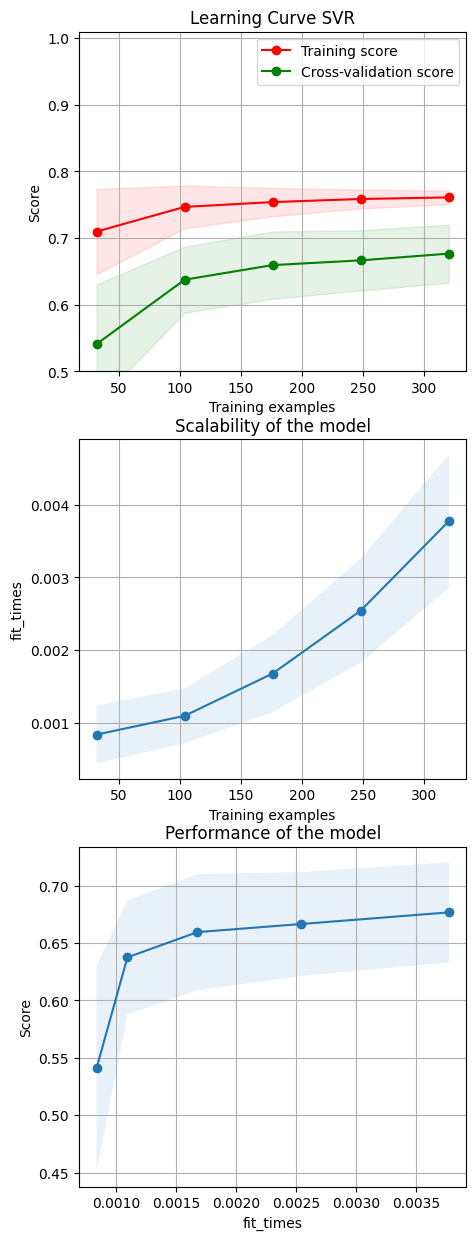

In [45]:
# plot SVR learning curves

fig, axes = plt.subplots(3, 1, figsize=(5, 15))
title = r"Learning Curve SVR"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = SVR()
plot_learning_curve(estimator, title, X, y, axes=axes, ylim=(0.5, 1.01), cv=cv, n_jobs=4)
plt.show()

Once again, the SVR model shows an improvement in its performance score, which reaches around 0.67. However, the model requires more time to train, as the time complexity follows a quadratic form. Moreover, there is a significant difference between the training and validation scores in this model, unlike our ridge model. Overall, the SVR model is not as effective as our previous ridge model.

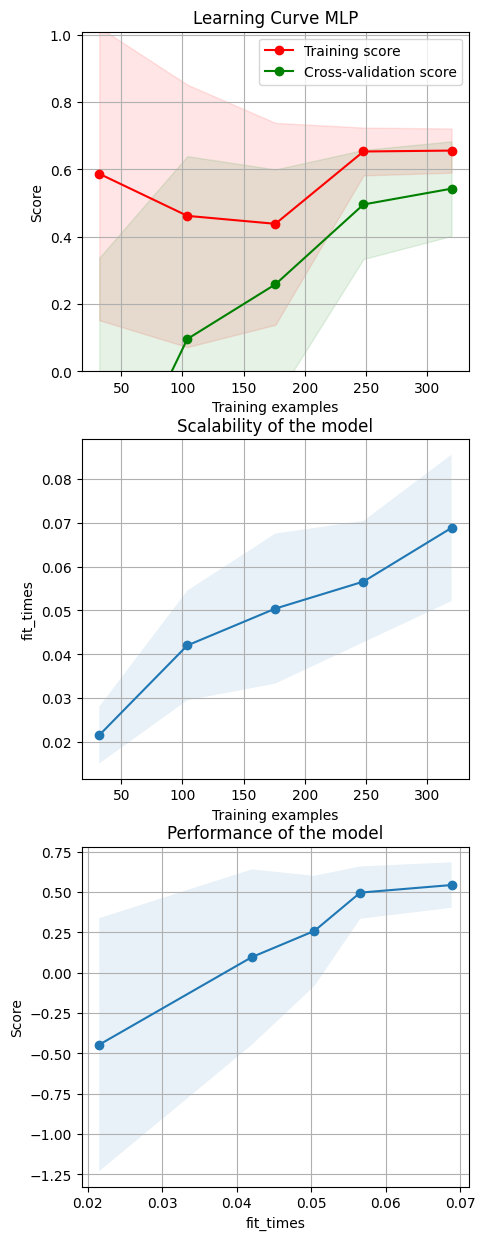

In [46]:
# plot MLP learning curves

fig, axes = plt.subplots(3, 1, figsize=(5, 15))

title = r"Learning Curve MLP"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = MLPRegressor()
plot_learning_curve(estimator, title, X, y, axes=axes, ylim=(0, 1.01), cv=cv, n_jobs=4)

plt.show()

The MLP model so far is the worst with a score of approzimately 0.5. it has has the longest time training and validating which puts it far below the other models.

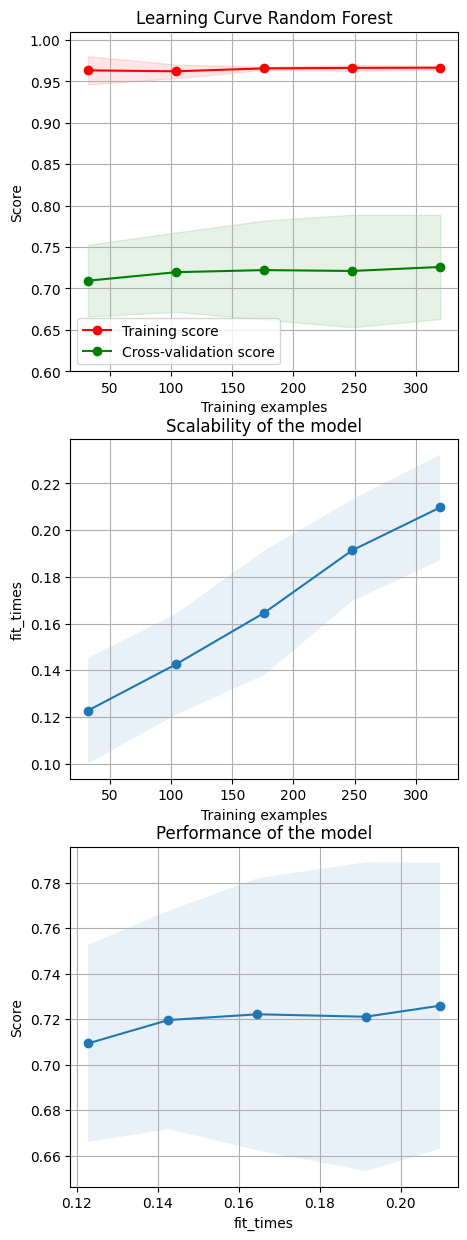

In [47]:
# plot Random Forest learning curves

fig, axes = plt.subplots(3, 1, figsize=(5, 15))
title = r"Learning Curve Random Forest"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = RandomForestRegressor()
plot_learning_curve(estimator, title, X, y, axes=axes, ylim=(0.6, 1.01), cv=cv, n_jobs=4)
plt.show()

Regarding the random forest model, the training score is nearly perfect, at approximately 0.96, and the validation score is also quite impressive. This is the first model that can compete with our ridge model. However, there are a few differences to note; the fitting time required for this model is much slower, and it would need more data samples for the training and validation scores to converge.

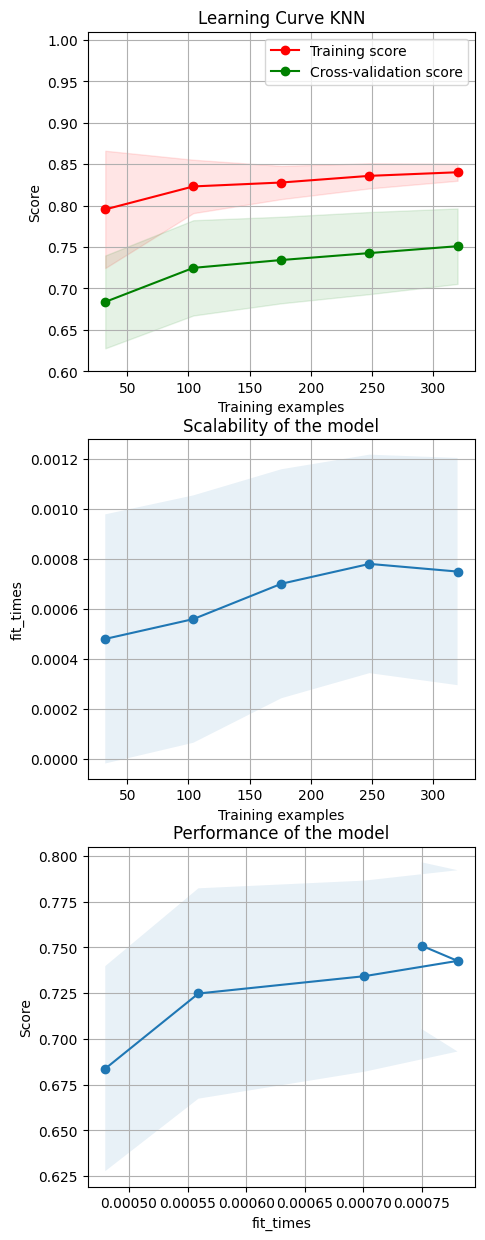

In [48]:
# plot KNN learning curves
fig, axes = plt.subplots(3, 1, figsize=(5, 15))
title = r"Learning Curve KNN"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = KNeighborsRegressor()
plot_learning_curve(estimator, title, X, y, axes=axes, ylim=(0.6, 1.01), cv=cv, n_jobs=4)
plt.show()

The KNN model that we developed is relatively effective, with decent performance for our dataset. Although the training and validation scores do not converge, they are not as different from each other as those in the random forest model. Additionally, the fitting time for this model is considerably lower than that of our other models. With a larger dataset, this model could potentially outperform our other models.

In [49]:
from sklearn.model_selection import GridSearchCV
def grigSearchRuner(clf, X, y, parameters):
    random_search = GridSearchCV(clf, parameters)
    random_search.fit(X, y)
    bestModelReport(random_search.cv_results_)

def bestModelReport(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model: {0}".format(i))
            print("Mean val: {0:.5f}"
                  .format(results['meanTest'][candidate]))
            print("Params: {0}".format(results['params'][candidate]))
            print("")

In [50]:
# optimize Ridge
params = {
    'alpha': np.linspace(0.001, 100, 100)
}
grigSearchRuner(Ridge(), X, y, params)

Model: 1


KeyError: 'meanTest'

In [ ]:
# optimize SVR 
params = {
    'kernel':['rbf', 'linear', 'poly', 'sigmoid'],
    'deg': [2, 3, 4, 5],
    'C': [0.01, 0.1, 1, 10],
    'ep': [0.05, 0.1, 0.15, .3, 1]
}
grigSearchRuner(SVR(), X, y, params)

Model with rank: 1
Mean validation score: 0.77517
Parameters: {'C': 0.01, 'degree': 2, 'epsilon': 0.05, 'kernel': 'linear'}

Model with rank: 1
Mean validation score: 0.77517
Parameters: {'C': 0.01, 'degree': 3, 'epsilon': 0.05, 'kernel': 'linear'}

Model with rank: 1
Mean validation score: 0.77517
Parameters: {'C': 0.01, 'degree': 4, 'epsilon': 0.05, 'kernel': 'linear'}

Model with rank: 1
Mean validation score: 0.77517
Parameters: {'C': 0.01, 'degree': 5, 'epsilon': 0.05, 'kernel': 'linear'}



In [ ]:
#optimized mlp
hiddenLaySize=[500, 200, 100, 50, 20, 10]
def powerset(seq):
    if len(seq) <= 0:
        yield []
    else:
        for item in powerset(seq[1:]):
            yield [seq[0]]+item
            yield item
hiddenLayPs = [p for p in powerset(hiddenLaySize)]
hiddenLayPs.sort()
hiddenLayPs.pop(0)

params = {
    'hiddenLayerSize': hiddenLayPs
}

grigSearchRuner(MLPRegressor(max_iter=500), X, y, params)

c:\Users\samta\OneDrive\Desktop\Racket\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Model with rank: 1
Mean validation score: 0.75880
Parameters: {'hidden_layer_sizes': [200, 100, 50, 20, 10]}

Model with rank: 2
Mean validation score: 0.72760
Parameters: {'hidden_layer_sizes': [500, 200, 100, 50, 20]}

Model with rank: 3
Mean validation score: 0.72531
Parameters: {'hidden_layer_sizes': [500, 200, 100, 20]}



In [ ]:
#optimized RF
params = {
    'nEstimators': [50, 100, 150, 200],
    'maxDepth': [3, 6, 9, None],
    'maxFeatures': [3, 6, 9, 11, None],
    'maxSamples': [100, 200, 300, None]
}
grigSearchRuner(RandomForestRegressor(), X, y, params)

Model with rank: 1
Mean validation score: 0.76996
Parameters: {'max_depth': 6, 'max_features': 6, 'max_samples': 100, 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.76881
Parameters: {'max_depth': 6, 'max_features': 6, 'max_samples': 100, 'n_estimators': 150}

Model with rank: 3
Mean validation score: 0.76589
Parameters: {'max_depth': 6, 'max_features': 9, 'max_samples': 100, 'n_estimators': 200}



In [ ]:
# Optimized KNN
params = {
    'nNeighbors':[i for i in range(1, 51)],
    'weight': ['uniform', 'distance'],
}
grigSearchRuner(KNeighborsRegressor(algorithm='kd_tree'), X, y, params)

Model with rank: 1
Mean validation score: 0.75705
Parameters: {'n_neighbors': 33, 'weights': 'distance'}

Model with rank: 2
Mean validation score: 0.75618
Parameters: {'n_neighbors': 34, 'weights': 'distance'}

Model with rank: 3
Mean validation score: 0.75612
Parameters: {'n_neighbors': 32, 'weights': 'distance'}



In [ ]:
# Testing five fold cross validation
ridgeAccuracy = fiveFoldCrossVal(X, y, Ridge(alpha=13.1322))
svrAccuracy = fiveFoldCrossVal(X, y, SVR(kernel='linear', C=0.01, epsilon=0.05))
mlpAccuracy = fiveFoldCrossVal(X, y, MLPRegressor([500, 200, 100, 50], max_iter=500))
rfAccuracy = fiveFoldCrossVal(X, y, RandomForestRegressor(max_depth=9, max_features=6, max_samples=100, n_estimators=100))
knnAccuracy = fiveFoldCrossVal(X, y, KNeighborsRegressor(n_neighbors=27, weights='distance'))
print(f"Optimized Ridge Regression : {ridgeAccuracy}")
print(f"Optimized SVR : {svrAccuracy}")
print(f"Optimized MLP Regressor: {mlpAccuracy}")
print(f"Optimized Random Forest: {rfAccuracy}")
print(f"Optimized KNN: {knnAccuracy}")

Optimized Ridge Regression : 0.794864812897323
Optimized SVR : 0.7911729957468949
Optimized MLP Regressor: 0.7775958743779363
Optimized Random Forest: 0.7757920240303443
Optimized KNN: 0.7711566553720924


We can see that our best model is still Ridge with SVR now coming in at a very close second with all being around 0.8. We can conclude that all other these models are decent options for regression, the best being ridge. Ridge has an apparent max while the others have room to improve given more data. Each has its benefits, it is important to test different models to find the best one 